# Gromos Tutorial

In [1]:
import os, sys, copy
root_dir = os.getcwd()
sys.path.append(root_dir+"/..")

#if package is not installed and path not set correct - this helps you out :)
import pygromos
from pygromos.utils import bash

## Project dir:
project_dir = os.path.abspath(os.path.dirname(pygromos.__file__)+"/../examples/example_files/Tutorial_System")
input_dir = project_dir+"/input"


## Build the input files
When a simulation study of a particular system or process is to be carried out, a number of choices have to
be made with respect to the set-up of the simulation. 
The first task is to generate a molecular topology file containing the topological and force-field data concerning the molecular system under consideration. Specifying a complete molecular topology for a large molecule, however, is a tedious task.
Therefore, in GROMOS a molecular topology is generated from molecular topology building blocks which carry the topological
information of molecules like amino acid residues, nucleotides, etc., see Vol. 3. The molecular topology building blocks can be linked together into a complete molecular topology file using the GROMOS++ program make top.
Many molecular topology building blocks are available in the molecular topology building block files (*.mtb), which are standard data files that come together with the GROMOS package. 
In case the needed molecular topology building blocks are not part of the standard distribution, they must be constructed. 
Constructing a new topology building block may require estimation of additional force-field parameters, which have to be added to the interaction function parameter file (*.ifp). 
When generating a molecular topology for the system of interest one should also address the protonation state of the molecular groups according to the pH and of the solvent and counter ions that need to be included in the simulation box. 
In case of a molecular complex, e.g. a DNA-protein complex, the two separately generated molecular topologies for the protein and the DNA can be merged using the GROMOS++ program com top.



In [2]:
from pygromos.files import gromos_system

build_system = gromos_system.Gromos_System(work_folder=project_dir, system_name='peptide')
build_system.work_folder = bash.make_folder(project_dir+"/a_build_initial_files")




	CHECK dependencies

Check /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System
/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System
All dependencies are correct! 


Generate Empty:  imd
Generate Empty:  top
Generate Empty:  cnf


/home/bschroed/Documents/projects/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:137: UserWarning: No data provided to gromos_system
manual work needed
  if verbose: warnings.warn("No data provided to gromos_system\nmanual work needed")
/home/bschroed/Documents/projects/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:565: UserWarning: Did not change file path as its only promised None
  if(self.verbose or True): warnings.warn("Did not change file path as its only promised " + str(file_obj.path))


### generate Topology
In this section you should build a molecular topology of a linear charged penta-peptide (Fig. 2.1) with water as a solvent, including two Cl− counter ions.

**programs: make_top, com_top, check_top**

#### build topology for single molecule
You will build the molecular topology file of the linear charged penta-peptide Val-Tyr-Arg-Lys-Gln by
using the GROMOS++ program make top. The input file make top peptide.arg is already prepared
and contains the following data: under the argument @build the molecular topology building block file is
specified. The argument @param specifies the interaction function parameter file. Under the argument @seq
the sequence of the building blocks for the amino acid residues, including the amino and carboxy terminus
is specified (NH3+ VAL TYR ARG LYSH GLN COO-). Notice that both termini are charged

In [3]:
from pygromos.data.ff import Gromos54A7

build_system.make_top(in_sequence="NH3+ VAL TYR ARG LYSH GLN COO-",
                     in_solvent="H2O",
                     in_building_block_lib_path = Gromos54A7.mtb,
                     in_parameter_lib_path= Gromos54A7.ifp)

build_system.top.RESNAME

RESNAME
5
VAL
TYR
ARG
LYSH
GLN
END

#### combine topology

Now we will combine the generated molecular topology files (peptide 54a7.top and Cl 54a7.top) into
the molecular topology file peptide 2Cl 54a7.top using the GROMOS++ program com top. The input
file com top peptide 2Cl.arg is already prepared and it contains the following data: under the argument
@topo the molecular topology files that you would like to combine are specified. Since two chloride ions
are needed to neutralize the charge of the penta-peptide, the molecular topology file of the chloride ion is
specified as 2:Cl 54a7.top. The arguments @param and @solv specify from which molecular topology file
the parameters for the solute and solvent should be taken. Since we use the same molecular topology building
block and interaction function files for both topologies, this is not important for us and both numbers are
set to 1. To run com top type:

### generate coordinates
Coordinates for biomolecules are often available from X-ray or NMR experiments and can be obtained in
Protein Data Bank (PDB) format, which can be converted to GROMOS format using the GROMOS++
program pdb2g96. However, the conversion is not always straightforward since the naming and numbering
of the atoms in the PDB format usually do not match the GROMOS format. Moreover, the coordinates for
hydrogen atoms are not present in the PDB files (when the structure was determined using X-ray diffraction
data) and have to be generated using the GROMOS++ program gch. When the structure is determined
using NMR data, the PDB structure often contains more hydrogen atoms than are needed for GROMOS,
as in the GROMOS force field only polar and aromatic hydrogens are explicitly represented. Aliphatic
hydrogens are non-existing due to the use of so-called united atoms. The aliphatic hydrogen and carbon
atoms are merged to form united atoms which have their own parameters. If no atomic coordinates for the
solute are available from experimental data, the coordinates have to be generated using molecular modeling
software. Often parts of the structure (e.g. flexible loops) are not resolved in the experiment and therefore
not available in the PDB and have to be modeled as well. When a simulation of a solute in solution is to be
carried out, a (periodic) box (be it rectangular, triclinic or truncated octahedral) is put around the solute
and filled with solvent molecules up to the required density. The solvent coordinates can e.g. be generated
using the GROMOS++ program sim box. The generated box should be sufficiently large to allow the
use of a reasonable non-bonded interaction cut-off radius. Putting the solute in a box of solvent using the
sim box program will result in several high-energy atom-atom contacts at the solute-solvent interface and
at the box edges. In order to relax the generated configuration the solvent configuration should be energy
minimized while positionally restraining the solute. Counter-ion atomic coordinates can then be generated
using the GROMOS++ program ion, which can replace a number of solvent molecules by ions.

**programs: pdb2g96, gch**


#### build coord file
Go into the subdirectory coord. Open the file peptide.pdb and check if the atom names match the names
in the molecular topology file peptide 2Cl 54a7.top.
In the pdb file peptide.pdb the coordinates for hydrogen atoms are not given and have to be generated.
Convert the PDB file peptide.pdb into the GROMOS format using the GROMOS++ program pdb2g96.
The hydrogen atoms will be added to the coordinate file according to the topological requirements. The
input arguments of the pdb2g96 program are self explanatory.

***
**Warning**: When converting coordinate files from the Protein Data Bank to GROMOS format many difficulties may emerge. If you encounter problems using the pdb2g96 program, have a look at Sec. 4-7.3. There
you can find further documentation on the advanced usage of this program. Especially the use of a library
that matches residue and atom names might be useful in many cases. pdb2g96.lib which you can find in
the directory is an example of the PDB library file.
***


In [4]:
build_system.pdb2gromos(in_pdb_path=input_dir+"/peptide.pdb")
build_system.rebase_files()

build_system.cnf.visualize()

File imd is empty , can not be written!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### add hydrogens
Have a look at the pdb2g96 peptide.cnf file. You will notice that the hydrogen atoms have been added
to the coordinate file with the Cartesian coordinates being set to zero. In order to generate meaningful
coordinates for the hydrogen atoms run the GROMOS++ program gch. It will generate the coordinates
for hydrogen atoms by geometric means using the information from the molecular topology file. Therefore,
the molecular topology file, peptide 2Cl 54a7.top, and the coordinate file, pdb2g96 peptide.cnf, have
to be specified in the gch input file. The argument @tol sets the tolerance that is used for keeping the
coordinates of hydrogens that are already present in the coordinate file.


In [5]:
build_system.protonate()

build_system.name = "peptideH"
build_system.rebase_files()

build_system.cnf.visualize()


File imd is empty , can not be written!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Optional: Convert cnf to pdb



In [6]:
pdb_path = build_system.cnf.write_pdb(build_system.work_folder+"/vacuum_hpeptide.pdb")
pdb_path

'/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/a_build_initial_files/vacuum_hpeptide.pdb'

### energy minimization - Vacuum

Before putting the penta-peptide into a box of solvent, its configuration has to be relaxed by energy
minimisation.

#### Simulation Parameters
he MD++ input file em peptide.imd contains the following blocks

In [7]:
from pygromos.data.simulation_parameters_templates import  template_emin_vac
from pygromos.files.simulation_parameters import imd

#load Imd File
emin_vac_imd_file = imd.Imd(template_emin_vac)


In the TITLE block you specify what is done with following input file.

In [8]:
emin_vac_imd_file.TITLE

TITLE
steepest descent energy minimization of the peptide in water

	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'	 comments_char: '#'
END

The existence of the ENERGYMIN block means that the MD++ program will perform an energy minimisation
(EM) run. The NTEM switch indicates which minimisation algorithm to be used. With NTEM = 1 we indicate
that the steepest-descent algorithm (Sec. 2-11.2) is used. NCYC gives the number of steps before resetting of
conjugate-gradient search direction in case we would use the conjugate gradient method (NTEM = 2). Using
DELE the energy threshold (the difference in energy between two energy minimisation steps) for stopping the
minimisation process (convergence) is specified. The initial step size and maximum step size is given in DX0
and DXM, respectively. Using FLIM the absolute value of the forces can be limited to a maximum value before
the algorithm is applied (see also 4-93).

In [9]:
emin_vac_imd_file.ENERGYMIN

ENERGYMIN
# 	 NTEM 	 NCYC 	 DELE 	 DX0 	 DXM 	 NMIN 	 FLIM
 	 1 	 0 	 0.1 	 0.01 	 0.05 	 2000 	 0.0 	 
END

In the SYSTEM block you specify the number of solutes (NPM) and solvent (NSM) molecules. You only have
one solute NPM = 1 and no solvent molecules NSM = 0 because you still did not add any solvent molecules
to the configuration file and the peptide is still in vacuum. Otherwise you would have to tell MD++ how
many solvent molecules you are using.

In [10]:
emin_vac_imd_file.SYSTEM


SYSTEM
# 	 NPM 	 NSM
 	 1 	 0 	 
END

The following block will be explained in more detail later


In [11]:
emin_vac_imd_file.STEP

STEP
# 	 NSTLIM 	 T 	 DT
 	 3000 	 0.000000 	 0.002000 	 
END

In the BOUNDCOND block you specify which periodic boundary conditions (PBC) you are going to use in the
EM procedure. NTB = 0 defines a vacuum simulation: PBC are not applied. To indicate the truncated
octahedron (t) PBC, NTB is set to -1, for rectangular (r) PBC NTB is 1, and for the triclinic (c) PBC NTB is
2. NDFMIN defines the number of degrees of freedom subtracted from the total number of degrees of freedom
for the calculation of the temperature.


In [12]:
emin_vac_imd_file.BOUNDCOND

BOUNDCOND
# 	 NTB 	 NDFMIN
 	 0 	 0 	 
END

With the PRINTOUT block you can specify how often (every NTPRth step) you are printing out the energies
to the output file.

In [13]:
emin_vac_imd_file.PRINTOUT

PRINTOUT
# 	 NTPR 	 NTPP
 	 10 	 0 	 
END

Bonds vibrate at high frequencies (hν ≫ kBT ). Therefore, these vibrations are of quantum-mechanical
nature. So constraining the bond lengths is a better approximation than treating them as classical harmonic
oscillators. Constraining all bond lengths of the solute and solvent (NTC=3) allows the use of a rather large
time step of 2 fs. In this example the constraints are imposed by the SHAKE algorithm for both solute
(NTCP=1) and solvent (NTCS=1) with a tolerance of 0.0001. See 4-90 for more information.

In [14]:
emin_vac_imd_file.CONSTRAINT

CONSTRAINT
# 	 NTC
 	 3 	 
# 	 NTCP 	 NTCP0(1)
 	 1 	 0.000100 	 
# 	 NTCS 	 NTCS0(1)
 	 1 	 0.000100 	 
END

In the FORCE block you tell MD++ which terms it should use for the energy and force calculation. For bond
angles, improper dihedrals, torsional dihedrals and the non-bonded interactions the standard terms of the
GROMOS force field are switched on (1). Because we are using bond-length constraints and the SHAKE
algorithm, we have to switch off (0) the bond-stretching terms for the bonds involving hydrogen atoms and
not involving hydrogen atoms..
In the last line of this block, the energy groups are defined. In general, we define one or more energy
groups for every molecule, and one comprising all the solvent molecules. The first integer is the number of
energy groups we want to use (in the present case we only have one energy group). The following numbers
are the atom sequence numbers of the last atom of each energy group. By defining these energy groups we
7-9
tell MD++ to sum up the energies between the atoms within these groups and calculate the inter-group
energies, which can be very useful.

In [15]:
emin_vac_imd_file.FORCE

FORCE
# 	 BONDS 	 ANGLES 	 IMPROPER 	 DIHEDRAL 	 ELECTROSTATIC 	 VDW
 	 1 	 1 	 1 	 1 	 1 	 1 	 
# 	 NEGR 	 NRE
 	 1 	 1 	 
END

In the PAIRLIST block you specify which algorithm you will use for the pairlist generation. The cut-off used
in the short-range pairlist construction is given by RCUTP and for GROMOS it is usually 0.8 nm. The cut-off
used in the long-range interactions is given by RCUTL and for GROMOS it is usually 1.4 nm. The pairlist is
generated every 5th (NSNB) step. TYPE specifies the type of the cut-off, whether it is based on the distance
between charge-groups (0) or on the distance between atoms (1).

***
**Warning**: Think very carefully about the definition of energy groups before running the simulation. Energies
of energy groups can not be calculated from the trajectories in an efficient way. So, changing an energy-group
definition will result in rerunning the simulation.
***


In [16]:
emin_vac_imd_file.PAIRLIST

PAIRLIST
# 	 ALGORITHM 	 NSNB 	 RCUTP 	 RCUTL 	 SIZE 	 TYPE
 	 0 	 5 	 0.800000 	 1.400000 	 0.4 	 0 	 
END

In the NONBONDED block you specify using NLRELE which method for the evaluation of long-range electrostatic
interactions is used. Since you will use the reaction-field method, the value of NLRELE should be equal to
1. The long-range electrostatic interactions are truncated beyond a certain cutoff (RCUTL in the PAIRLIST
block). Beyond the reaction-field cut-off radius (RCRF) the electrostatic interactions are replaced by a static
reaction field with a dielectric permittivity of EPSRF. RCRF and RCUTL should be identical. Because we are
doing the energy minimisation in vacuo EPSRF is set to 1. With NSLFEXCL equal to 1, you include the
contributions of excluded atoms to the electrostatic energy. The ionic strength of the continuum is set to 0
(APPAK). All other switches are not used for the reaction-field method. See 4-98 for more information.


In [17]:
emin_vac_imd_file.NONBONDED

NONBONDED
# 	 NLRELE
 	 1 	 
# 	 APPAK 	 RCRF 	 EPSRF 	 NSLFEXCL
 	 0.0 	 1.4 	 61 	 1 	 
# 	 NSHAPE 	 ASHAPE 	 NA2CLC 	 TOLA2 	 EPSLS
 	 -1 	 1.4 	 2 	 1e-10 	 0 	 
# 	 NKX 	 NKY 	 NKZ 	 KCUT
 	 10 	 10 	 10 	 100 	 
# 	 NGX 	 NGY 	 NGZ 	 NASORD 	 NFDORD 	 NALIAS 	 NSPORD
 	 32 	 32 	 32 	 3 	 2 	 3 	 4 	 
# 	 NQEVAL 	 FACCUR 	 NRDGRD 	 NWRGRD
 	 100000 	 1.6 	 0 	 0 	 
# 	 NLRLJ 	 SLVDNS
 	 0 	 33.3 	 
END

#### Perform Emin
In order to run the MD++ program, a shell script needs to be prepared. Open the shell script em peptide.
run and adapt the paths and the names of the files according to your system.


In [18]:
from pygromos.simulations.modules.preset_simulation_modules import emin

out_prefix = "emin_vacuum"

## Preparing emin gromos system
in_emin_system = build_system.copy()
in_emin_system.work_folder = project_dir
in_emin_system.imd = emin_vac_imd_file #template_emin_vac

from pygromos.files.blocks.imd_blocks import WRITETRAJ
in_emin_system.imd.add_block(block=WRITETRAJ(NTWE=25, NTWX=25))

in_emin_system.prepare_for_simulation()

in_emin_system

/home/bschroed/Documents/projects/PyGromosTools/pygromos
/home/bschroed/Documents/projects/PyGromosTools/pygromos
/home/bschroed/Documents/projects/PyGromosTools/pygromos



GROMOS SYSTEM: peptideH
################################################################################
WORKDIR: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System
LAST CHECKPOINT: None

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/bschroed/Documents/projects/PyGromosTools/pygromos/data/simulation_parameters_templates/vac_emin.imd
	top: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/peptideH.top
	cnf: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/peptideH.cnf
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	[]  resID: []  natoms: 0
	Non-LIGANDS:	[]  nmolecules: 0  natoms: 0
	SOLVENT:	[]  nmolecules: 0  natoms: 0



In [19]:
out_emin_system = emin(in_gromos_system=in_emin_system,
                       step_name="b_"+out_prefix)

################################################################################

b_emin_vacuum
################################################################################

Script:  /home/bschroed/Documents/projects/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  3000
equis:  0
simulation runs:  1
################################################################################

 submit Final AnaLysis part 

/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/b_emin_vacuum/ana_out.log
/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/b_emin_vacuum/job_analysis.py
ANA jobID: 0


#### Analysis 
Once the energy minimisation is finished, the file with the minimized coordinates, peptide min.cnf, and the general output file, em peptide.omd, that reports the progress of the minimisation, will be written out.
Have a look at both files and check if the minimisation has finished successfully. 



In [20]:
 out_emin_system.cnf.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This is nice, but how do we actually get to this structure!

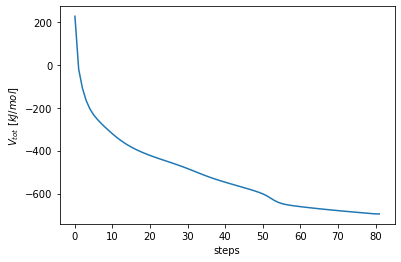

In [21]:
out_emin_system.tre.get_totals().totene.plot(xlabel="steps", ylabel="$V_{tot}~[kJ/mol]$")
pass

In [40]:
view = out_emin_system.trc.visualize(out_emin_system.cnf)
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Finally we wan to store our energy minimization results as a python pickle obj.

In [23]:
out_emin_system_path = out_emin_system.save(out_emin_system.work_folder+"/emin_vac_result.obj")
out_emin_system_path

'/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/emin_result.obj'

## Solvatistation and Solvent Energy Minimization

Now you can put the energy minimized penta-peptide in a box of solvent using the GROMOS++ program
sim box which can solvate the solute in a pre-equilibrated box of solvent molecules. Go to the subdirectory
box. In the input file for the program sim box you have to specify the following input arguments: the
molecular topology file under the argument @topo, the resulting box shape under the argument @pbc (rrectangular, t-truncated octahedron, c-triclinic), the coordinate file of the solute under the argument @pos,
the coordinate file of the pre-equilibrated box of solvent molecules under the argument @solvent, minimum
solute-to-wall distance under the argument @minwall, and the minimum solute-to-solvent distance under
the argument @thresh. If you are using a rectangular box (@pbc r) it is recommended to use an additional
argument, @rotate. With this additional argument the solute can be rotated (before solvating) such that
the largest distance between any two solute atoms is directed along the z-axis, and the largest atom-atom
distance in the xy-plane lies in the y-direction. An input file sim box peptide.arg is already prepared. To
put the solvent box around the penta-peptide type:


### build box system

In [24]:
from pygromos.data.solvent_coordinates import spc

box_system = out_emin_system.copy() 
box_system.imd = None
box_system.name = "solvate_box"
box_system.work_folder = bash.make_folder(project_dir+"/c_"+box_system.name)
#box_system = gromos_system.Gromos_System.load(out_emin_system_path)


## set box and solvate the system
box_system.sim_box(in_solvent_cnf_file_path=spc,
                 periodic_boundary_condition="r", 
                 minwall=0.8, 
                 threshold=0.23, 
                 rotate=True)

#box_system.cnf
box_system.rebase_files()
box_system.cnf.visualize()

sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
/home/bschroed/Documents/projects/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:794: UserWarning: did not find the required imd found
  warnings.warn("did not find the required " + file_name + " found")


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Add Ions

In [25]:
from pygromos.data.solvent_coordinates import spc

## Build directory
ion_system = box_system.copy() 
ion_system.name = "ion"
ion_system.work_folder = bash.make_folder(project_dir+"/d_"+ion_system.name)

ion_system.ion(negative=[2, "CL-"])


ion_system.rebase_files()
ion_system.cnf.visualize()

sh: 0: getcwd() failed: No such file or directory


ion @topo /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/ion.top @pos /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/ion.cnf @pbc v @potential 0.8 @mindist 0.8 @negative 2 CL-


sh: 0: getcwd() failed: No such file or directory


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Energy Minimization BOX

In order to relax the unfavorable atom-atom contacts between the solute and the solvent, energy minimisation of the solvent should be performed while keeping the solute positionally restrained (i.e. connecting the atom to a reference position by a spring). In order to do that two additional files, in which the positionally restrained atoms and the reference coordinates are specified, have to be generated from the coordinate file sim box peptide.cnf. Copy the coordinate file sim box peptide.cnf to sim box peptide.por and to sim box peptide.rpr. Open the new file sim box peptide.por with a text editor, write in the TITLE block the text “solute atoms to be positionally restrained”, and delete all the coordinates of the solvent such that only the coordinates of the solute atoms are left. Then change the keyword POSITION at the beginning
of the atom coordinate block of sim box peptide.por to POSRESSPEC. You now have a file containing a POSRESSPEC block which only contains the atoms of the peptide. With these changes the position restraints specification file sim box peptide.por should look like this:

#### build posistion restraints
The preparation of the reference position file is even simpler as it is very similar to the coordinate file and only the TITLE block has to be changed and one block has to be renamed. In order to prepare the reference position file, open the new file sim box peptide.rpr in a text editor, write in the TITLE block the text “reference positions for restraining solute atoms”, and change the block name POSITION to REFPOSITION.
Warning: When reading in a coordinate file with a POSITION block the first 24 characters (atom specification) are ignored. However, in a position restraints file each line of the POSRESSPEC block must have seven columns as the fourth to seventh column are read in by the program.
The MD++ input files for minimisation of the solvent around the penta-peptide, em solvent.imd, and the script to run the minimisation, em solvent.run, are already prepared. Nevertheless, open the em solvent.imd and compare it with em peptide.imd. You will notice that em solvent.imd contains one input block more, the POSITIONRES block.


In [27]:
from pygromos.simulations.modules.preset_simulation_modules import emin
from pygromos.data.simulation_parameters_templates import template_emin

## Preparing emin gromos system
out_prefix = "emin_solvBox"
in_eminBox_system = ion_system.copy()
in_emin_system.work_folder= project_dir

### Build position restraints
restrain_res = [k for k in in_eminBox_system.cnf.residues if(not k in ("CL-", "SOLV"))]
in_eminBox_system.generate_posres(residues=restrain_res)

### Check simulation params
in_eminBox_system.imd = template_emin 

in_eminBox_system.prepare_for_simulation()

in_eminBox_system


GROMOS SYSTEM: ion
################################################################################
WORKDIR: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion
LAST CHECKPOINT: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/emin_result.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/bschroed/Documents/projects/PyGromosTools/pygromos/data/simulation_parameters_templates/emin.imd
	top: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/ion.top
	cnf: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/ion.cnf
	posres: None
	refpos: None
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	['CL6', 'CL7']  resID: [6, 7]  natoms: 2
	Non-LIGANDS:	[]  nmolecules: 0  natoms: 0
	SOLVENT:	SOLV  nmolecules: 930  natoms: 2790



#### Perform Emin

In [28]:
## run emin
out_eminBox_system = emin(in_gromos_system=in_eminBox_system, 
                          step_name="e_"+out_prefix)

out_eminBox_system.cnf.visualize()

sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory


################################################################################

e_emin_solvBox
################################################################################

Script:  /home/bschroed/Documents/projects/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  3000
equis:  0
simulation runs:  1


sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory


################################################################################

 submit Final AnaLysis part 

/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/e_emin_solvBox/ana_out.log
/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/e_emin_solvBox/job_analysis.py
ANA jobID: 0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
out_eminBox_system_path = out_eminBox_system.save(out_eminBox_system.work_folder+"/emin_box_result.obj")


## Thermalisation and equilibration.

In the previous steps you have generated a topology and initial coordinates of your system. At this point,
you have to generate initial velocities. In the process of thermalisation and equilibration, initial velocities
are sampled from a Maxwell-Boltzmann distribution at a low temperature and the system is slowly heated
up to the final production simulation temperature. The atoms of the solute are positionally restrained and
these restraints are loosened while heating up. With the help of these restraints you make sure that the
random initial velocities do not disrupt the initial conformation too much.
You already know a couple of things about job scripts. Because the set-up of a job script can be a laborintensive undertaking, there is a little but powerful helper called mk script. This GROMOS++ program
is able to automatically generate a job script from a given input file and a series of arguments.
Before we have a detailed look at mk script, let’s see which MD++ input file we need for the thermalisation and equilibration period. Go to the subdirectory eq. Open the equilibration.imd file. This file
contains a series of input blocks some of which you have already seen at the energy minimisation step. Here
only new or changed input blocks are explained.

### Simulation Paramters

In [29]:
from pygromos.data.simulation_parameters_templates import template_md_tut as template_md
md_imd_file = imd.Imd(template_md)


md_imd_file.INITIALISE

INITIALISE
# 	 NTIVEL 	 NTISHK 	 NTINHT 	 NTINHB
 	 1 	 0 	 0 	 0 	 
# 	 NTISHI 	 NTIRTC 	 NTICOM
 	 1 	 0 	 1 	 
# 	 NTISTI
 	 0 	 
# 	 IG 	 TEMPI
 	 12416 	 300.0 	 
END

In the INITIALISE block the NTIVEL tells GROMOS whether it should generate the initial velocities or
read them from the configuration file. NTISHK is used to restore bond length constraints (SHAKE). NTINHT
and NTINHB are only used for Nose-Hoover thermo- and barostats and can be ignored in our case. Every
time an atom is leaving the periodic box and entering it from the opposite site this incident is recorded in
the so-called lattice shift vectors. Using NTISHI we want to make sure that these vectors are initialised to
zero. As you don’t want to use roto-translational constraints NTIRTC can be ignored. NTICOM is used for
initial removal of centre of mass motion. NTISTI is used to reset the stochastic integrals used in stochastic
dynamics (SD) simulations. IG is the random number generator seed and TEMPI the initial temperature used
to generate the Maxwell-Boltzmann distribution for generation of initial velocities. See also 4-94 for more
information.
In the SYSTEM block you need to replace NSM with the number of solvent molecules in your system (you will
find it in peptide 2Cl h2o.cnf file).


In [30]:
md_imd_file.STEP

STEP
# 	 NSTLIM 	 T 	 DT
 	 1000 	 0.000000 	 0.002000 	 
END

In the STEP block you specify how many steps you want to simulate (NSTLIM), at what time your simulation
starts (T) and how big the integration time step (DT) is. In this case you want to start at time 0 and you
want to carry out a 20 ps simulation, because the time unit happens to be ps.

In [31]:
md_imd_file.BOUNDCOND

BOUNDCOND
# 	 NTB 	 NDFMIN
 	 1 	 3 	 
END

As previously described, with the BOUNDCOND block you specify which PBC you will use. With NTB=1 you
specify rectangular PBC.

In [32]:
md_imd_file.MULTIBATH

MULTIBATH
# ALGORITHM
  0
# NBATHS
  2
# TEMP0(1 ... NBATHS) 	 TAU(1 ... NBATHS)
  300.0 	 0.1
  300.0 	 0.1
# DOFSET
  2
# LAST(1 ... DOFSET) 	 COMBATH(1 ... DOFSET) 	 IRBATH(1 ... DOFSET)
  73 	 1 	 1
  2863 	 2 	 2
END

In our case we want to run the simulation at constant temperature. For this purpose, we have to add the
MULTIBATH input block (see 4-96). First we specify which algorithm we will use. In this case we will use
the weak-coupling scheme (ALGORITHM=0). How many temperature baths we want to couple to the system
is specified by NBATHS. You can specify the temperature using the TEMP0 parameter. TAUT is the coupling
time used in the weak-coupling method for this bath. DOFSET specifies the number of distiguishable sets
of degrees of freedom. LAST is pointing to the last atom for the set of degrees of freedom; thus, you put
the number of last atom of your system instead of LSTATM. COMBATH is the temperature bath to which we
want to couple the centre of mass motion of this set of degrees of freedom IRBATH is the temperature bath
to which the internal and rotational degrees of freedom of this set of degrees of freedom are coupled. The
temperatures in this block are modified by mk script.

In [33]:
md_imd_file.COMTRANSROT

COMTRANSROT
# 	 NSCM
 	 1000 	 
END

This block is needed to remove the centre of mass motion (translation and rotation). Without this block it
can happen that all the kinetic energy is converted to centre of mass translation (flying ice cube problem).
With NSCM we specify how often the center-of-mass (COM) motion is removed. If NSCM is < 0 translation
and rotation motion are removed every |NSCM|th step. If NSCM is > 0 only translation motion is removed
every NSCMth step.

In [34]:
md_imd_file.COVALENTFORM

COVALENTFORM
# 	 NTBBH 	 NTBAH 	 NTBDN
 	 0 	 0 	 0 	 
END

This block is needed to define which functional form we will use for bond-stretching (NTBBH), bond-angle
bending (NTBAH) and for torsional dihedral (NTBDN). We just use the default options for all functional forms.

In [35]:
md_imd_file.WRITETRAJ

WRITETRAJ
# 	 NTWX 	 NTWSE 	 NTWV 	 NTWF 	 NTWE 	 NTWG 	 NTWB
 	 10 	 0 	 0 	 0 	 10 	 0 	 0 	 
END

MD++ produces a massive amount of data and it is impossible to store all the data it produces. The
WRITETRAJ block meets this demand: Here you specify how often the coordinate trajectory (NTWX), the
velocity trajectory (NTWV), the force trajectory (NTWF), the energy trajectory (NTWE), the free energy trajectory
(NTWG) and the block averaged energy trajectory (NTWB) are written out. In the present case, we are only
interested in the coordinates (NTWX) and energies (NTWE) and we write them every 100th step. The second
switch (NTWSE) defines selection criterion for trajectories: if NTWSE = 0 the normal coordinate trajectory will
be written, or if NTWSE > 0 a minimum energy trajectory will be written.

***

**Warning**: It makes no sense to write out configurations too often. First, it needs a lot of disk space. Second,
the data is highly correlated and so no additional information is gained from it
***

In [36]:
md_imd_file.PRINTOUT

PRINTOUT
# 	 NTPR 	 NTPP
 	 250 	 0 	 
END

This block is very similar to the WRITETRAJ block but the information about the energies (NTPR) is printed
to the output file. By giving NTPP, dihedral angle transitions are written to the special trajectory.
In the FORCE block you need to replace the LSTATM with the number of last atom of your system.


In [37]:
md_imd_file.PAIRLIST

PAIRLIST
# 	 ALGORITHM 	 NSNB 	 RCUTP 	 RCUTL 	 SIZE 	 TYPE
 	 1 	 5 	 0.800000 	 1.400000 	 0.4 	 0 	 
END

MD++ knows different algorithms for the generation of the pairlist, a list containing the atoms interacting
with each other. Here, we use a grid based pairlist generation: the space is discretized into grid cells and
only the neighboring cells are searched for interacting partners. The use of this algorithm results in a
The pairlist is generated every 5th (NSNB) step. RCUTP and RCUTL are the cutoffs for the pairlist construction for
the short-range and the long-range interactions.
The pairlist is generated every 5th (NSNB) step. RCUTP and RCUTL are the cutoffs for the pairlist construction for
the short-range and the long-range interactions.

In [38]:
from pygromos.files.blocks.imd_blocks import POSITIONRES

md_imd_file.add_block(block=POSITIONRES(NTPOR=1, NTPORB=1, CPOR=25000))

md_imd_file.POSITIONRES

POSITIONRES
# 	 NTPOR 	 NTPORB 	 NTPORS 	 CPOR
 	 1 	 1 	 0 	 25000 	 
END

Finally, we want to restrain the position of our solute. The restraining is achieved by a harmonic special
force term with a force constant of CPOR. This force constant is also modified by mk script.
Now you should understand the main blocks of the MD++ input files.


### Perform Thermalisation
Now it is time to have a look at mk script. Open the input file eq mk script.arg. Here choose a system
name @sys, describing your simulation. @bin points to the MD++ executable md and @dir points to the
directory where the simulation files are. Using the @files argument you specify all the files needed by your
simulation (topology, MD++ input file, initial coordinate file, position restraints and reference position
file). @template respectively mk script.lib is a configuration file for mk script. Therein you can adapt
mk script to your local system or cluster. Because we are using MD++ you have to give the @version md++
argument. Finally, you tell mk script what to do, using a joblist file that you specify with the @joblist
argument.

***
**Warning**: Depending on your system’s speed this will take up to five hours. As we are using the simulation
directory as the working directory there will be an error message after every job which can be ignored.
***

***
 *Hint* : Have a look at all the output files eq peptide *.omd. If anything goes wrong, a message will be
printed to the output file.
***

In [41]:
from pygromos.simulations.modules.preset_simulation_modules import md

## Preparing emin gromos system
out_prefix = "eq_thermalisation"
in_eq_system = out_eminBox_system.copy()

### Build position restraints
restrain_res = [k for k in in_eq_system.cnf.residues if(not k in ("CL-", "SOLV"))]
in_eq_system.generate_posres(residues=restrain_res)

### Check simulation params
in_eq_system.imd = md_imd_file 

in_eq_system.prepare_for_simulation(not_ligand_residues=["CL-"])

in_eq_system


GROMOS SYSTEM: e_emin_solvBox
################################################################################
WORKDIR: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion
LAST CHECKPOINT: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/emin_result.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/bschroed/Documents/projects/PyGromosTools/pygromos/data/simulation_parameters_templates/md_tut.imd
	top: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/e_emin_solvBox.top
	cnf: /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/e_emin_solvBox.cnf
	posres: None
	refpos: None
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	[]  resID: []  natoms: 0
	Non-LIGANDS:	['CL-']  nmolecules: 0  natoms: 2
	SOLVENT:	SOLV  nmolecules: 930  natoms: 2790



In [42]:
## run EQ
from pygromos.simulations.modules.general_simulation_modules import simulation

temperatures = [60, 120, 180, 240, 300] 

print("Heating upt to: ", end="\t")
for runID, temperature in enumerate(temperatures):
    print(temperature, end="\t")
    
    #adapt temperature
    in_eq_system.imd.MULTIBATH.TEMP0 = [temperature for x in range(in_eq_system.imd.MULTIBATH.NBATHS)]
    
    #turn off the posres for the last run.
    if(runID+1 == len(temperatures)):
        print("LAST")
        in_eq_system.imd.POSITIONRES.NTPOR = 0
        in_eq_system.imd.POSITIONRES.CPOR = 0
        
        # Last run
        out_eq_system = simulation(in_gromos_simulation_system=in_eq_system, 
                                   step_name="f_"+out_prefix, 
                                   simulation_runs=runID+1)

    else:
        out_eq_system = simulation(in_gromos_simulation_system=in_eq_system, 
                                   step_name="f_"+out_prefix, 
                                   simulation_runs=runID+1, 
                                   analysis_script=None,
                                   verbose=False)
print("done")

Heating upt to: 	60	

sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
/home/bschroed/Documents/projects/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:565: UserWarning: Did not change file path as its only promised /home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/f_eq_thermalisation/analysis/data/f_eq_thermalisation.cnf
  if(self.verbose or True): warnings.warn("Did not change file path as its only promised " + str(file_obj.path))


120	180	240	300	LAST
################################################################################

f_eq_thermalisation
################################################################################

Script:  /home/bschroed/Documents/projects/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  1000
equis:  0
simulation runs:  5
################################################################################

 submit Final AnaLysis part 

/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/f_eq_thermalisation/ana_out.log
/home/bschroed/Documents/projects/PyGromosTools/examples/example_files/Tutorial_System/d_ion/f_eq_thermalisation/job_analysis.py
ANA jobID: 0
done


In [ ]:
out_eq_therm_system_path = out_eq_therm_system.save(out_eq_system.work_folder+"/eq_therm_result.obj")


The joblist is already prepared for you. Therein you can change parameters in the MD++ input file for
a certain job. Have a look into the file:

    All the jobs have a certain ID which you can find in the first column. The following columns specify the
parameters of the MD++ input file that you want to change. In the first job, we have to generate the initial
velocities. Thus, we give an initial temperature (TEMPI) and set the NTIVEL parameter to one. In the further
jobs we will read the velocities from a file, hence we set NTIVEL to 0. You can see that we are increasing
the temperature for both baths by 60K at every new job (TEMP0[1..2]). Simultaneously, the force constant
(CPOR) for the position restraints is decreased by an order of magnitude at every new job. Finally, in the last
columns you specify in which subdirectory and in what order you want to run the jobs. The only thing that
is missing to start the equilibration are the files containing the position restraints of the solute. To prepare it,
copy the coordinate file peptide 2Cl h2o.cnf from the ion directory to the local directory and open it with
a text editor and prepare the files peptide 2Cl h2o.por and peptide 2Cl h2o.rpr as you prepared the files
sim box peptide.por and sim box peptide.rpr for the energy minimisation of the solvent (Sec. 2.2.3).


### Analysis of Thermalisation:
This creates five eq peptide *.run job scripts and the corresponding input files (eq peptide *.imd).

***
*Warning*: mk script will not complain if the refpos file is not found! And the MD++ will crash if the
POSRESSPEC block contains an empty line (only whitespace) at the end of the file!
You are now ready to start the thermalisation and equilibration. Run the first job script and the others
will be automatically executed as soon as the preceding script has finished.
***

#### Check the coordinate traj

In [43]:
coordinate_traj = out_eq_system.trc
coordinate_traj.cog_reframe(out_eq_system.cnf)
view = coordinate_traj.visualize(out_eq_system.cnf)

In [44]:
#view

#### Check the temperature

In [45]:
energy_traj = out_eq_system.tre
temperatures= energy_traj.get_temperature()
temperatures

,TIMESTEP_time,TIMESTEP_step,bath1,bath2
0,0.00,0,256.687114,303.465372
1,0.02,10,140.446778,390.619534
2,0.04,20,158.525744,384.232110
3,0.06,30,194.740922,380.077395
4,0.08,40,148.299974,350.391783
...,...,...,...,...
491,9.82,4910,279.247225,298.033014
492,9.84,4920,285.647675,303.919189
493,9.86,4930,229.495281,304.042465
494,9.88,4940,258.853854,297.280224


AttributeError: 'DataFrame' object has no attribute 'bath3'

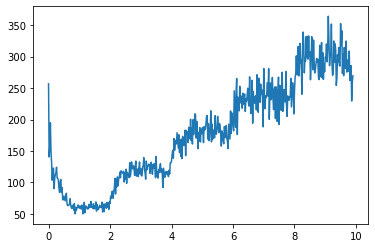

In [46]:
from matplotlib import pyplot as plt

plt.plot(temperatures.TIMESTEP_time, temperatures.bath1, label="TBath1")
plt.plot(temperatures.TIMESTEP_time, temperatures.bath2, label="TBath2")

plt.legend()
plt.ylabel("$T~[K]$")
plt.xlabel("$t~[ps]$")

## Molecular dynamics sampling simulation.


### Simulation Paramters
The equilibration period already produced a short simulation at constant temperature and volume. At
this point we want to elongate the simulation to a nanosecond under constant temperature and pressure.
Go to the directory md and use the mk script program to create the job scripts and the input files.
Have a look at the input file md.imd. Compared to the file used for the equilibration there are only a few
differences: First, we don’t use position restraining anymore and so, the POSITIONRES block was removed.
We want to simulate under constant pressure rather than constant volume. For this purpose we have to add
an additional block:



In [ ]:
from pygromos.data.simulation_parameters_templates import template_md_tut as template_md
imd_file = imd.Imd(template_md)

imd_file.PRESSURESCALE

In the PRESSURESCALE block we tell MD++ to calculate and scale the pressure by setting COUPLE to 2. As
the box should be isotropically scaled we set SCALE equal to 1. The weak-coupling method (Sec. 2-12.2.2)
uses two additional parameters: COMP is the isothermal compressibility and TAUP is the coupling time. We
are calculating the molecular virial (VIRIAL is equal to 2), so intramolecular forces don’t contribute to the
pressure. The next line is only used for semi-anisotropic pressure coupling and can be ignored in our case.
Finally, we have to specify the reference pressure in a tensor form

### Perform MD - Production
In the other blocks only minor things have changed: the temperature was set to 300K and the trajectories
are written out less often (every 250th step only). In the mk script input file (md mk script.arg) the
specifications of the position restraints file and the joblist file are not needed any more. Instead of the joblist
we use the @script argument. Here, we tell mk script to create 10 consecutive scripts, beginning with the
first (1)

In [ ]:
from pygromos.simulations.modules.preset_simulation_modules import md

## Preparing emin gromos system
out_prefix = "md"

out_eq_system._trc = None
out_eq_system._tre = None


in_md_system = out_eq_system.copy()
in_md_system.posres = None
in_md_system.refpos = None


### Check simulation params
in_md_system.imd = imd_file 

## imd parameters
in_md_system.imd.STEP.NSTLIM = 1000
in_md_system.imd.WRITETRAJ.NTWX = 10
in_md_system.imd.WRITETRAJ.NTWE = 10
in_md_system.imd.INITIALISE.NTIVEL = 0

in_md_system.prepare_for_simulation()

in_md_system

In [ ]:
out_md_system = md(in_gromos_system=in_md_system, 
                   step_name="g_"+out_prefix, 
                   simulation_runs=3)


In [ ]:
out_md_system_path = out_md_system.save(out_md_system.work_folder+"/md_result.obj")


After all the jobs are finished, you should start to analyse the trajectories.


### Analysis

#### First Look Analysis

In [ ]:
out_md_system.cnf.visualize()


In [ ]:
coordinate_traj = out_md_system.trc
coordinate_traj.cog_reframe(out_md_system.cnf)
view = coordinate_traj.visualize(out_md_system.cnf)

In [ ]:
#view


#### Energy Analysis
The program calculates the average of the specified properties as well as the root-mean-square deviations
(rmsd) and a statistical error estimate (error est.). The error estimate is calculated from block averages
of growing sizes extrapolating to infinite block size1
.
Warning: Sometimes the error estimates are NaN (not a number), which is due to the fact that we do not
have enough values to calculate a meaningful error estimate.

In [ ]:
energy_traj = out_md_system.tre
total_energies = energy_traj.get_totals()
total_energies

In [ ]:
from matplotlib import pyplot as plt

plt.plot(energy_traj.database.TIMESTEP_time, total_energies.totene)

plt.ylabel("$V_{tot}~[kJ]$")
plt.xlabel("$t~[ps]$")

i.e. we add up the van der Waals and Coulomb energies2
of the peptide-peptide interactions. Now define
three more variables which you could call, e.g. e pCl1 (peptide with first chloride), e pCl2 (peptide with
second chloride), e pwater (peptide with water). Now you can specify these newly defined variables as
properties (@prop) in the ene ana peptide.arg file. ene ana will then produce the following four files:


In [ ]:
energy_traj.database.nonbonded.apply(lambda x: x[:0])

#### Coordinate Analysis

In [ ]:
coordinate_traj.rmsd(out_md_system.cnf)

In [ ]:
type(out_md_system.cnf)